In [18]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

In [19]:
import DarkVerse as dv


In [20]:

# Define the home directory
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Load Catalog Data
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits")  
t = Table.read(fits_file_path)

masked_file_path = os.path.join(thesis_path, "COSMOS_masked_cat.fits")  
t3 = Table.read(masked_file_path)

# Join tables on 'id'
t = join(t, t3, keys='id')
t.rename_column('ra_1', 'ra')
t.rename_column('dec_1', 'dec')

# Load Randoms
fits_random = os.path.join(thesis_path, "COSMOS_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'
}

z_min=0.3
z_max=0.5
SM_min=9
SM_max=10

# Select Subsample
subsample = dv.Subsample(catalog=t, randoms=randoms, z_min=z_min, z_max=z_max, SM_min=SM_min, SM_max=SM_max, config=config)

# Get Results
results = subsample.get_results()

print(f"Power Law Parameters (A, gamma): {results['power_law_params']}")
print()
#print(f"w_theta: {results['w_theta']}")
#print(f"DD counts: {results['dd_counts']}")
#print(f"DR counts: {results['dr_counts']}")
#print(f"RR counts: {results['rr_counts']}")


Power Law Parameters (A, gamma): [0.00517884 0.75143114]



Errors on w_theta: [2.92642139e-01 2.74820333e-01 2.59622896e-01 2.64915775e-01
 2.56557795e-01 2.37716317e-01 2.48875074e-01 2.50237009e-01
 2.44488117e-01 2.51587621e-01 2.48237003e-01 2.44713866e-01
 2.39766022e-01 2.46246810e-01 2.42730831e-01 2.41533952e-01
 2.36517799e-01 2.37514091e-01 2.37479889e-01 2.37547914e-01
 2.34497617e-01 2.32968206e-01 2.28479957e-01 2.27430205e-01
 2.25097849e-01 2.18868338e-01 2.16346476e-01 2.07426686e-01
 2.00859987e-01 1.94303202e-01 1.85334916e-01 1.79274825e-01
 1.68236526e-01 1.58250952e-01 1.47510441e-01 1.38936675e-01
 1.26904146e-01 1.18218429e-01 1.12194255e-01 1.12384007e-01
 1.11984756e-01 1.10496571e-01 1.06211455e-01 1.02440034e-01
 9.19651428e-02 8.43337718e-02 8.47618728e-02 8.53750679e-02
 8.63897872e-02 8.25237920e-02 7.36884113e-02 7.11957195e-02
 7.31039681e-02 7.74238796e-02 7.03250308e-02 7.30163131e-02
 7.98260250e-02 7.62572295e-02 8.08822905e-02 9.67451102e-02
 1.06153346e-01 2.10022667e-01 1.30032116e+00 4.45595889e+02]


/tmp/ipykernel_3873019/2901281716.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


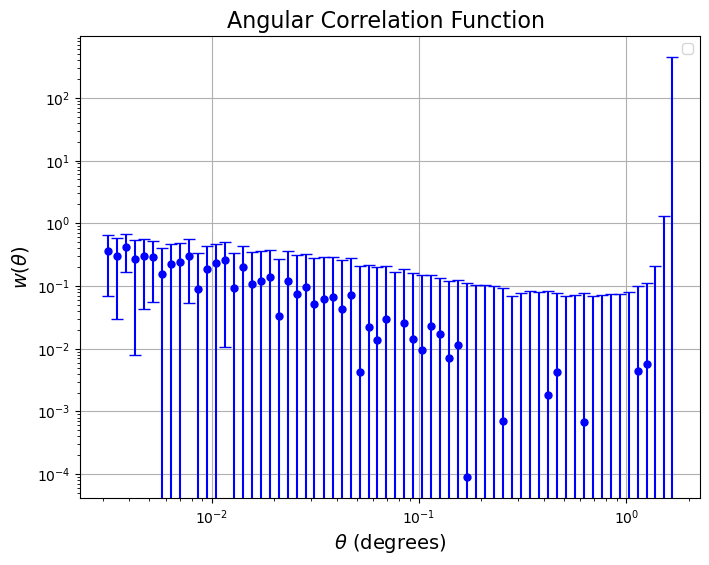

In [21]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)


plt.figure(figsize=(8, 6))
plt.errorbar(theta_values, w_theta_values, yerr= w_theta_errors, fmt='o', color='blue', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()


### ^these errors are way too big wtf is going on??

In [22]:
gg = subsample.compute_gg()  



In [23]:
print(f"xi g: {results['xi_g']}")


xi g: [4.48556928 4.12006423 3.77217413 3.44240884 3.13114854 2.83863491
 2.56495861 2.31006118 2.073738   1.85563814 1.65527713 1.47204855
 1.30524272 1.15407769 1.01764213 0.89486414 0.78474045 0.68635825
 0.598748   0.52096372 0.45197527 0.39075041 0.33595826 0.28608592
 0.2418042  0.20384419 0.17237165 0.14748217 0.12867818 0.11452174
 0.10381617 0.09562252 0.08921425 0.08403913 0.07968663 0.07586025
 0.07235348 0.06902889 0.0658002  0.06261738 0.05945473 0.05630205
 0.0531585  0.05002878 0.04692096 0.04384508 0.04081217 0.03783365
 0.03492107 0.03208565 0.02933817 0.02668896 0.02414769 0.02172328
 0.0194237  0.01725569 0.01522459 0.01333432 0.01158737 0.00998484
 0.00852631 0.00720991 0.00603255 0.00498986]


In [24]:


# Compute correlation functions
theta, xi_g, xi_m = subsample.compute_gg()

# Retrieve all results
results = subsample.get_results()

# Print key outputs
print("Galaxy-Galaxy Angular Correlation:", results['xi_g'])
print("Matter-Matter Angular Correlation:", results['xi_m'])


Galaxy-Galaxy Angular Correlation: [4.48556928 4.12006423 3.77217413 3.44240884 3.13114854 2.83863491
 2.56495861 2.31006118 2.073738   1.85563814 1.65527713 1.47204855
 1.30524272 1.15407769 1.01764213 0.89486414 0.78474045 0.68635825
 0.598748   0.52096372 0.45197527 0.39075041 0.33595826 0.28608592
 0.2418042  0.20384419 0.17237165 0.14748217 0.12867818 0.11452174
 0.10381617 0.09562252 0.08921425 0.08403913 0.07968663 0.07586025
 0.07235348 0.06902889 0.0658002  0.06261738 0.05945473 0.05630205
 0.0531585  0.05002878 0.04692096 0.04384508 0.04081217 0.03783365
 0.03492107 0.03208565 0.02933817 0.02668896 0.02414769 0.02172328
 0.0194237  0.01725569 0.01522459 0.01333432 0.01158737 0.00998484
 0.00852631 0.00720991 0.00603255 0.00498986]
Matter-Matter Angular Correlation: [0.48401108 0.46968079 0.45485693 0.43956922 0.42385368 0.40775333
 0.3913149  0.37459107 0.35764096 0.34052658 0.32331455 0.3060753
 0.28888121 0.27180662 0.25492667 0.23831645 0.22205001 0.20619963
 0.19083495 0.

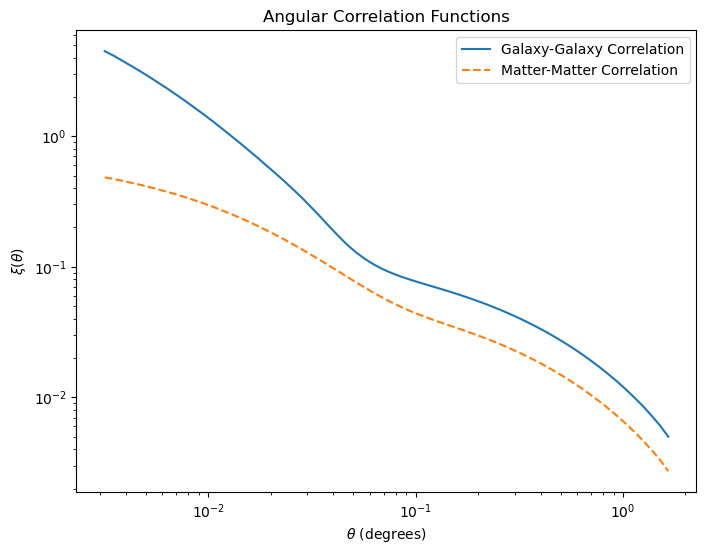

In [25]:
plt.figure(figsize=(8,6))
plt.loglog(results['theta'], results['xi_g'], label='Galaxy-Galaxy Correlation')
plt.loglog(results['theta'], results['xi_m'], label='Matter-Matter Correlation', linestyle='dashed')

plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi(\theta)$')
plt.legend()
plt.title('Angular Correlation Functions')
plt.show()


Errors on w_theta: [2.92642139e-01 2.74820333e-01 2.59622896e-01 2.64915775e-01
 2.56557795e-01 2.37716317e-01 2.48875074e-01 2.50237009e-01
 2.44488117e-01 2.51587621e-01 2.48237003e-01 2.44713866e-01
 2.39766022e-01 2.46246810e-01 2.42730831e-01 2.41533952e-01
 2.36517799e-01 2.37514091e-01 2.37479889e-01 2.37547914e-01
 2.34497617e-01 2.32968206e-01 2.28479957e-01 2.27430205e-01
 2.25097849e-01 2.18868338e-01 2.16346476e-01 2.07426686e-01
 2.00859987e-01 1.94303202e-01 1.85334916e-01 1.79274825e-01
 1.68236526e-01 1.58250952e-01 1.47510441e-01 1.38936675e-01
 1.26904146e-01 1.18218429e-01 1.12194255e-01 1.12384007e-01
 1.11984756e-01 1.10496571e-01 1.06211455e-01 1.02440034e-01
 9.19651428e-02 8.43337718e-02 8.47618728e-02 8.53750679e-02
 8.63897872e-02 8.25237920e-02 7.36884113e-02 7.11957195e-02
 7.31039681e-02 7.74238796e-02 7.03250308e-02 7.30163131e-02
 7.98260250e-02 7.62572295e-02 8.08822905e-02 9.67451102e-02
 1.06153346e-01 2.10022667e-01 1.30032116e+00 4.45595889e+02]


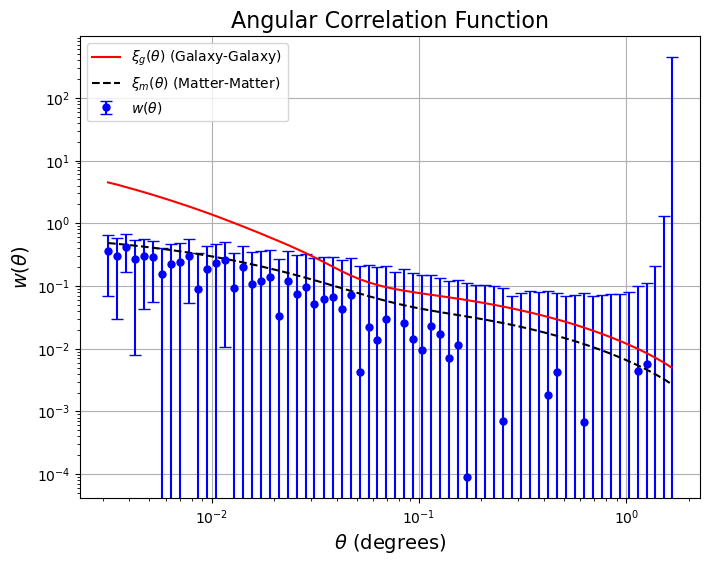

In [26]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']
xi_g_values = results['xi_g']
xi_m_values = results['xi_m']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)

# Create figure
plt.figure(figsize=(8, 6))

# Plot w(theta) with error bars
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label=r'$w(\theta)$')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

# Log-log scales
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [27]:


bias_estimator = dv.BiasEstimator(
    xi_g=results['xi_g'],
    xi_m=results['xi_m'],
    w_theta_list=[results['w_theta']], 
    w_theta_error_list=[results['var_w_theta']], 
    sum_rr_list=[results['rr_counts']], 
    mask = (theta_values >= 0.1) & (theta_values <= 0.4)
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


Bias values: [0.971247887364167]
Bias errors: [0.05010488464173554]


In [28]:
xi_m_values = np.array(results['xi_m'])  # Matter-matter correlation function
IC_values = np.array(bias_estimator.IC_list)  # Integral Constraint correction

# Compute the model: xi_m * b^2 - IC
model_values = xi_m_values * bias_values[0]**2 - IC_values[0]  # single subsample

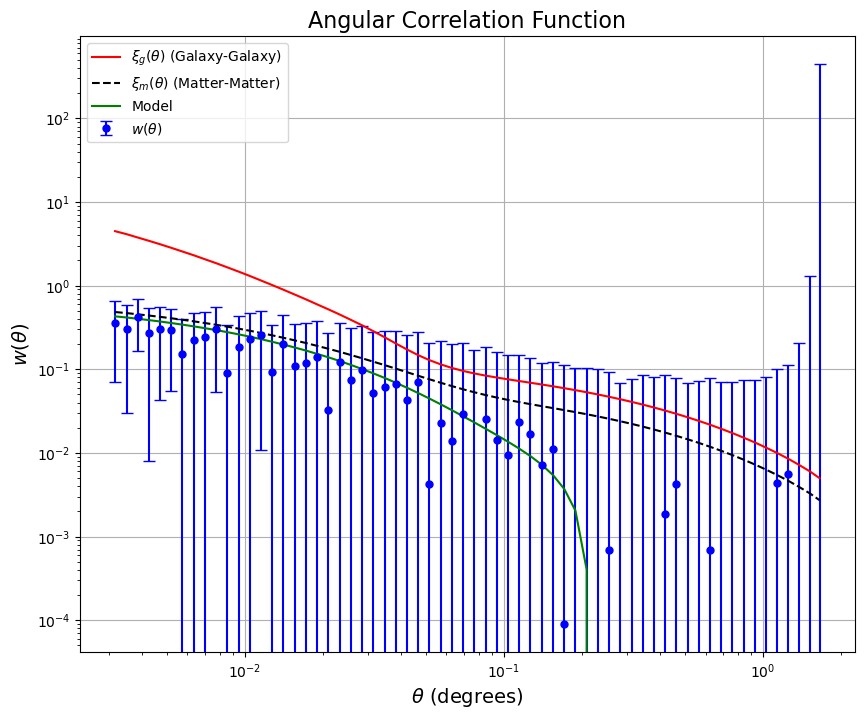

In [29]:
plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label=r'$w(\theta)$')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.plot(theta_values, model_values, label=r'Model', color='g')
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

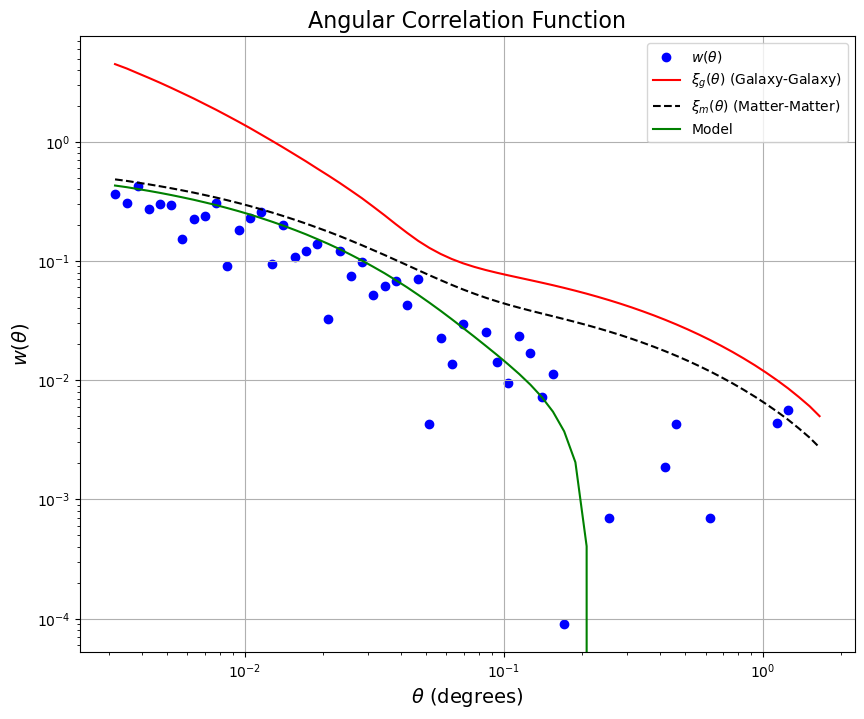

In [30]:
plt.figure(figsize=(10, 8))
plt.scatter(theta_values, w_theta_values,  
             color='blue',  label=r'$w(\theta)$')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.plot(theta_values, model_values, label=r'Model', color='g')
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [33]:

print("\n--- Subsample Information ---")
print(f"Redshift range: {subsample.z_min} ≤ z ≤ {subsample.z_max}")
print(f"Stellar Mass range: {subsample.SM_min} ≤ SM ≤ {subsample.SM_max}")
print(f"Number of galaxies in subsample: {len(subsample.filtered_catalog)}")
print(f"Power-law Fit Parameters (A, γ): {results['power_law_params']}")



--- Subsample Information ---
Redshift range: 0.3 ≤ z ≤ 0.5
Stellar Mass range: 9 ≤ SM ≤ 10
Number of galaxies in subsample: 4515
Power-law Fit Parameters (A, γ): [0.00517884 0.75143114]
